# Explore mcmc results and create dataframes of parameters and ccn results.

In [119]:

from models import CCNmodel_m2
from config import get_Extra, load_data
import pints
import pints.io
import pints.plot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import matplotlib.gridspec as gridspec
from scipy.stats import skew
from scipy.stats import mode
import seaborn as sns
import pickle
import scipy.stats as stats

In [2]:
# make trace plots:
def trace_plot(plt_samples, burn_in, initial_guess, param_name):
    f,axs = pints.plot.trace(plt_samples[:, :, :], parameter_names=[param_name])
    f.set_figheight(5)
    axs[0][0].axvline(x=plt_samples[:, burn_in:, :].mean(), color='r', linestyle='--', label='mcmc mean '+str(np.round(plt_samples[:, burn_in:, :].mean(),3)))
    axs[0][0].axvline(x=np.median(plt_samples[:, burn_in:, :]), color='r', label='mcmc median '+str(np.round(np.median(plt_samples[:, burn_in:, :]),3)))
    axs[0][0].axvline(x=mode(plt_samples[:, burn_in:, :],axis=None)[0], linestyle=':', color='r', label='mcmc mode '+str(np.round(mode(plt_samples[:, burn_in:, :],axis=None)[0],3)))
    axs[0][0].axvline(x=initial_guess, color='b', linestyle='--', label='initial guess')
    axs[0][0].legend()
    axs[0][1].axvline(x=burn_in, color='grey', linestyle='--')

In [3]:
nedmead_results = pd.read_csv('../results/result_nedler_mead_org0p12.csv')

bimodal_params = pd.read_csv('../input_data/bimodal_params_windows.csv')

## Example analysis of one time-step (trace plots and marginal pdfs):

In [92]:
# window idx for example:
idx = 5917

#set number of discarded iterations:
burn_in = 20000

#get chains for that window:
chains = sorted(glob.glob('../chains/mcmc_30k_m2_restarts_*'+str(idx)+'_*.csv'))
chains

['../chains/mcmc_30k_m2_restarts_5chains_5917_0.csv',
 '../chains/mcmc_30k_m2_restarts_5chains_5917_1.csv',
 '../chains/mcmc_30k_m2_restarts_5chains_5917_2.csv',
 '../chains/mcmc_30k_m2_restarts_5chains_5917_3.csv',
 '../chains/mcmc_30k_m2_restarts_5chains_5917_4.csv']

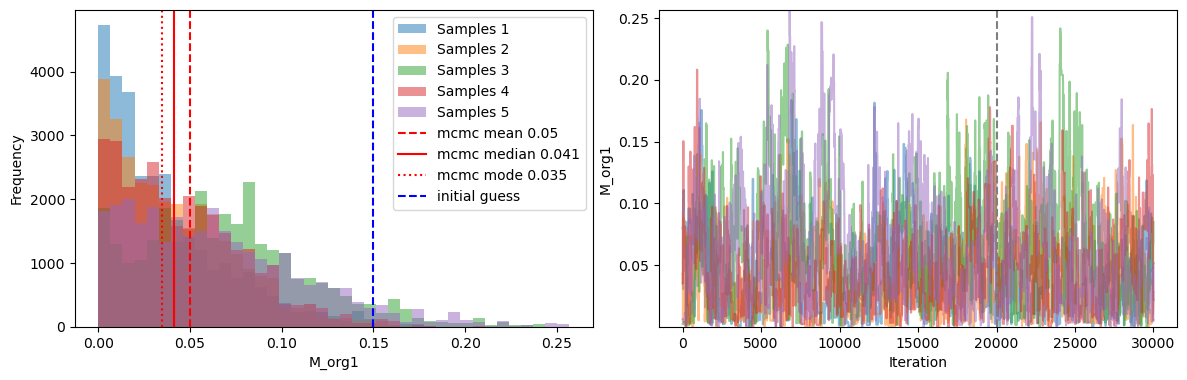

In [93]:
# load data:
M_org1_chains = pints.io.load_samples(chains[0])
D1_chains = pints.io.load_samples(chains[1])
N1_chains = pints.io.load_samples(chains[2])
D2_chains = pints.io.load_samples(chains[3])
N2_chains = pints.io.load_samples(chains[4])

#get initial guesses for parameters:
bimodal_params = pd.read_csv('../input_data/bimodal_params_windows.csv')
M_org1_initial = pd.read_csv('../input_data/M_org1_initialguess.csv')

trace_plot(np.expand_dims(M_org1_chains, axis=2), burn_in, M_org1_initial['M_org1'][20], 'M_org1')

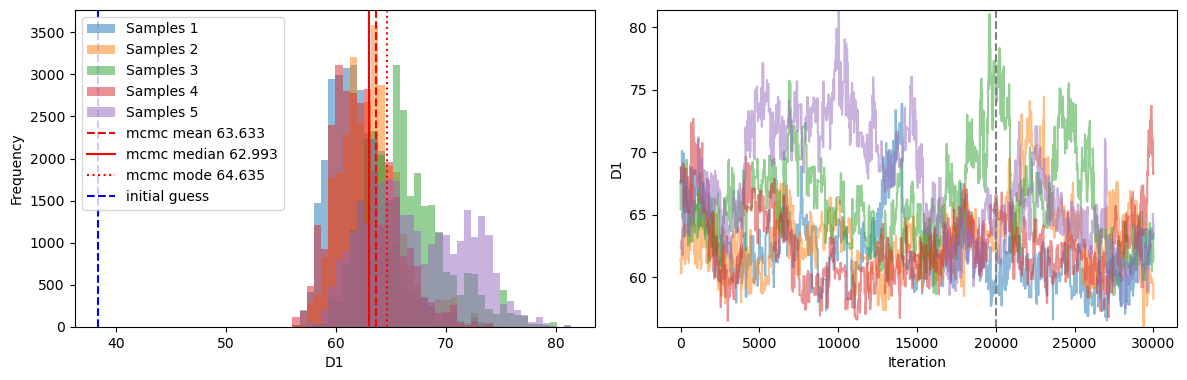

In [94]:
trace_plot(np.expand_dims(D1_chains, axis=2), burn_in, bimodal_params['mode1_d'][20], 'D1')

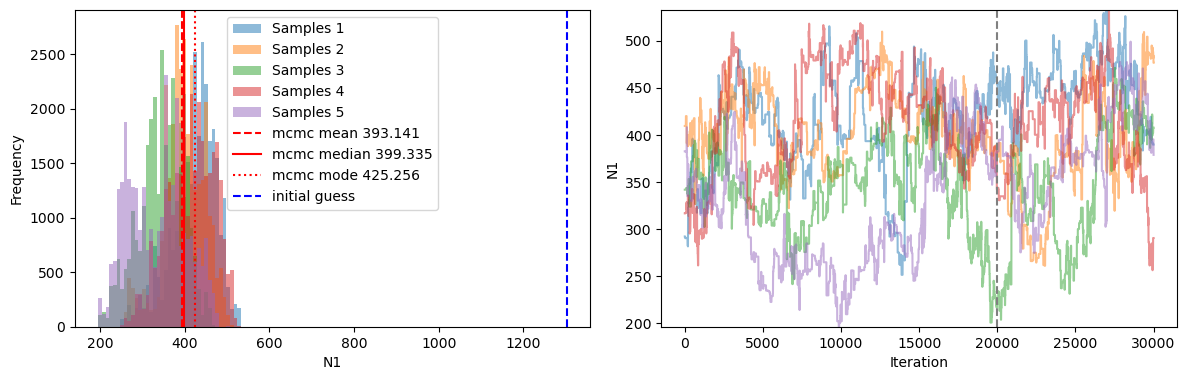

In [82]:
trace_plot(np.expand_dims(N1_chains, axis=2), burn_in, bimodal_params['NSD1_sum'][20], 'N1')

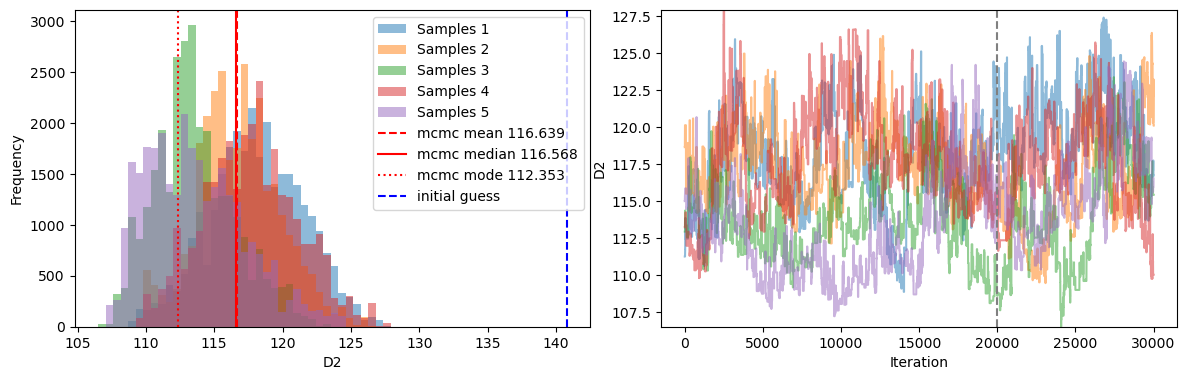

In [83]:
trace_plot(np.expand_dims(D2_chains, axis=2), burn_in, bimodal_params['mode2_d'][20], 'D2')

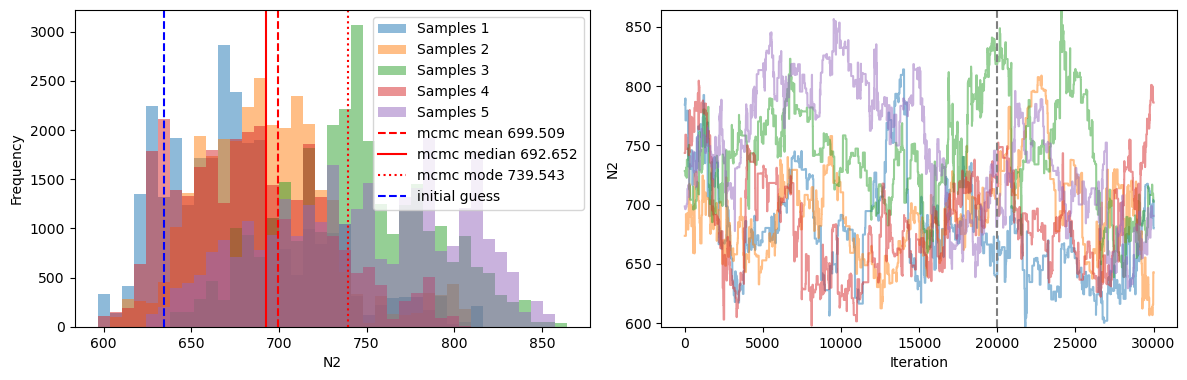

In [84]:
trace_plot(np.expand_dims(N2_chains, axis=2), burn_in, bimodal_params['NSD2_sum'][20], 'N2')

In [85]:
# print rhat statistics:
cut_off = 0.6
print('M_org1 rhat:', pints.rhat(M_org1_chains, cut_off), 
      'D1 rhat:', pints.rhat(D1_chains, cut_off),
      'N1 rhat:', pints.rhat(N1_chains, cut_off),
      'D2 rhat:', pints.rhat(D2_chains, cut_off),
      'N2 rhat:', pints.rhat(N2_chains, cut_off))

# print ess statistics:
#samples = np.column_stack([M_org1_chains[:,burn_in:].reshape(-1), D1_chains[:,burn_in:].reshape(-1), N1_chains[:,burn_in:].reshape(-1), D2_chains[:,burn_in:].reshape(-1), N2_chains[:,burn_in:].reshape(-1)])
#print('total ess:', pints.effective_sample_size(samples))

M_org1 rhat: 1.0787413619386101 D1 rhat: 1.3682455692574285 N1 rhat: 1.449783716065552 D2 rhat: 1.3364235648672003 N2 rhat: 1.4174523610517515


(<Figure size 1500x1500 with 25 Axes>,
 array([[<Axes: ylabel='Frequency'>, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >],
        [<Axes: ylabel='D1'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: ylabel='N1'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: ylabel='D2'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: xlabel='M_org1', ylabel='N2'>, <Axes: xlabel='D1'>,
         <Axes: xlabel='N1'>, <Axes: xlabel='D2'>, <Axes: xlabel='N2'>]],
       dtype=object))

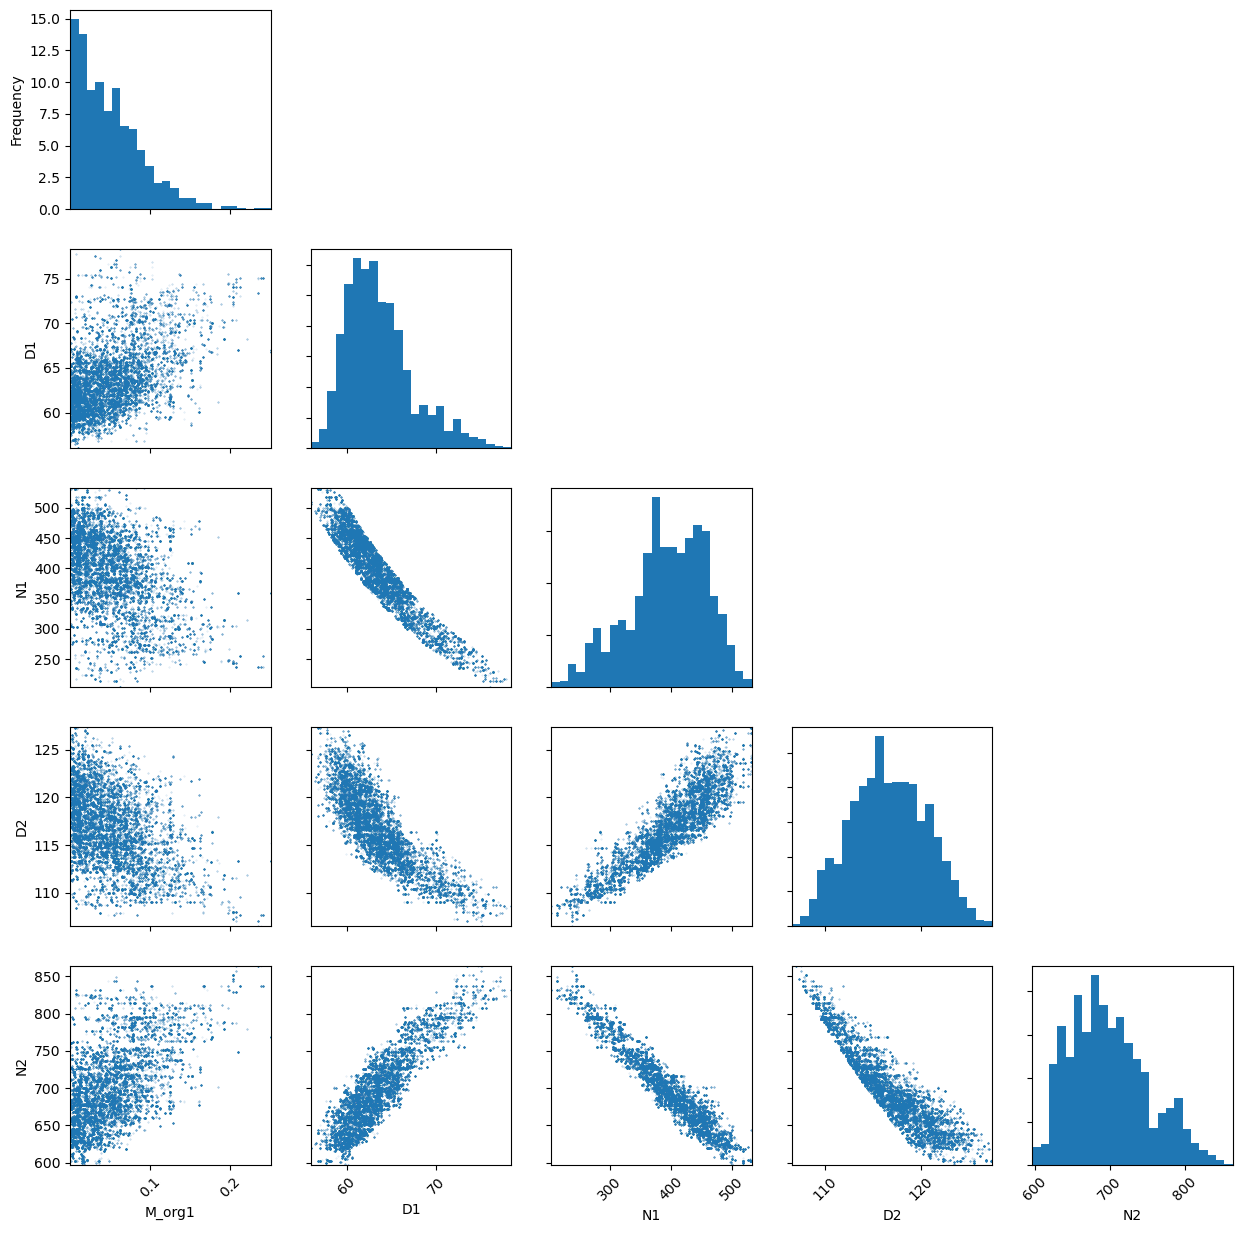

In [86]:
samples = np.stack([M_org1_chains[:,burn_in:], D1_chains[:,burn_in:], N1_chains[:,burn_in:], D2_chains[:,burn_in:], N2_chains[:,burn_in:]], axis=2)
pints.plot.pairwise(np.vstack(samples), kde=False, parameter_names=['M_org1', 'D1', 'N1', 'D2', 'N2'])

In [87]:
nedmead_results['Predicted_CCN'][idx]

'[307.73520234 519.14231086 604.66480262 666.25093373 708.23040221]'

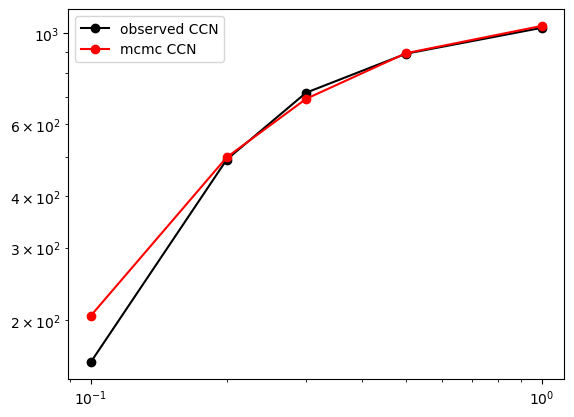

In [88]:
# compare CCN spectra:

# setup model:
Extra = get_Extra(idx)
model_data, initial_guesses, prior_params, response = load_data(idx)
m = CCNmodel_m2(Extra, model_data, return_all=True)

test_model_output = m(np.mean(samples, axis=(0,1)))

ss = [0.1,0.2,0.3,0.5,1.0]

#nedmead_ccn = np.fromstring(nedmead_results['Predicted_CCN'][idx]) 

plt.loglog(ss, response, label='observed CCN', color='k', marker='o')
plt.loglog(ss, test_model_output[0]+test_model_output[1], label='mcmc CCN', color='r', marker='o')
#plt.loglog(ss, nedmead_ccn, label='ned-mead CCN', color='b', marker='o')
plt.legend()

## Main data processing (create parameter dataframe and CCN results dataframe):

To get parameter values and statistics, run summarize_mcmc_posteriors.py

In [95]:
# load mcmc parameters for summary statistics and calculate CCN results:
mcmc_params = pd.read_csv('../results/summary_30k_m2_5chains_20kburn.csv')

In [52]:
# calculate mcmc results (or load farther down)
mcmc_results = pd.DataFrame({'datetime': mcmc_params['datetime']})

cols_to_add = [
    'NRMSE', 'predicted_CCN1', 'predicted_CCN2', 'inorg_density', 'Predicted_CCN',
    'f_org1', 'f_AS1', 'f_BC1', 'f_org2', 'f_AS2', 'f_BC2',
    'k1', 'k2', 'mass_aitken', 'mass_accumulation'
]

for col in cols_to_add:
    if col in ['predicted_CCN1', 'predicted_CCN2', 'Predicted_CCN']:
        mcmc_results[col] = pd.Series([np.nan]*5, dtype='object')
    else:
        mcmc_results[col] = np.nan

check_rows = []

all_cols_to_nan = mcmc_results.columns.difference(['datetime'])

for ii in range(2000):

    # skip rows with NaN:
    if pd.isna(mcmc_params.iloc[ii]).any():
        mcmc_results.loc[ii, all_cols_to_nan] = np.nan

    else:
        try:
            Extra = get_Extra(ii)
            model_data, initial_guesses, prior_params, response = load_data(ii)
            m = CCNmodel_m2(Extra, model_data, return_all=True)

            model_parameters = [mcmc_params.iloc[ii]['M_org1_median'], mcmc_params.iloc[ii]['D1_median'], mcmc_params.iloc[ii]['N1_median'], mcmc_params.iloc[ii]['D2_median'], mcmc_params.iloc[ii]['N2_median']]
            ccn1, ccn2, k1, k2, k_inorg1, k_inorg2, mass_frac_aitken, mass_frac_accumulation, total_ait_mass, total_acc_mass, total_mass,info_mass, NSD1_vec, NSD2_vec = m(model_parameters)

            nrmse = np.sqrt(np.mean((response - (ccn1+ccn2))**2)) / np.mean(response)

            mcmc_results.at[ii, 'NRMSE'] = nrmse
            mcmc_results.at[ii, 'predicted_CCN1'] = ccn1
            mcmc_results.at[ii, 'predicted_CCN2'] = ccn2
            mcmc_results.at[ii, 'inorg_density'] = Extra['rho_inorg']
            mcmc_results.at[ii, 'Predicted_CCN'] = ccn1 + ccn2
            mcmc_results.at[ii, 'f_org1'] = mass_frac_aitken[0]
            mcmc_results.at[ii, 'f_AS1'] = mass_frac_aitken[2]
            mcmc_results.at[ii, 'f_BC1'] = mass_frac_aitken[4]
            mcmc_results.at[ii, 'f_org2'] = mass_frac_accumulation[0]
            mcmc_results.at[ii, 'f_AS2'] = mass_frac_accumulation[2]
            mcmc_results.at[ii, 'f_BC2'] = mass_frac_accumulation[4]
            mcmc_results.at[ii, 'k1'] = k1
            mcmc_results.at[ii, 'k2'] = k2
            mcmc_results.at[ii, 'mass_aitken'] = total_ait_mass
            mcmc_results.at[ii, 'mass_accumulation'] = total_acc_mass

        except Exception as e:
            print(f"No model output for median parameters for row {ii}: {e}")
            mcmc_results.loc[ii, all_cols_to_nan] = np.nan
            check_rows.append(ii)
            continue



No model output for median parameters for row 171: cannot unpack non-iterable NoneType object
No model output for median parameters for row 644: cannot unpack non-iterable NoneType object
No model output for median parameters for row 1392: cannot unpack non-iterable NoneType object


In [15]:
mcmc_results.to_csv('../results/30k_m2_5chain_uniformM1_ccn_results.csv')

In [42]:
mcmc_results = pd.read_csv('../results/30k_m2_5chains_ccn_results.csv')

In [114]:
# how many time-steps show convergence:
rhat_thresh = 1.3
num_conv = mcmc_params.where(mcmc_params['M_org1_rhat'] < rhat_thresh).where(mcmc_params['D1_rhat'] < rhat_thresh).where(mcmc_params['N1_rhat'] < rhat_thresh).where(mcmc_params['D2_rhat'] < rhat_thresh).where(mcmc_params['N2_rhat'] < rhat_thresh).dropna()

print(f"Number of total time-teps showing convergence (rhat < {rhat_thresh}): {num_conv.shape[0]} out of {len(mcmc_params.dropna())}")
print(f"Number of time-steps showing M_org1 convergence (rhat < {rhat_thresh}): {mcmc_params.where(mcmc_params['M_org1_rhat'] < rhat_thresh).dropna().shape[0]} out of {len(mcmc_params.dropna())}")
print(f"Number of time-steps showing D1 convergence (rhat < {rhat_thresh}): {mcmc_params.where(mcmc_params['D1_rhat'] < rhat_thresh).dropna().shape[0]} out of {len(mcmc_params.dropna())}")
print(f"Number of time-steps showing N1 convergence (rhat < {rhat_thresh}): {mcmc_params.where(mcmc_params['N1_rhat'] < rhat_thresh).dropna().shape[0]} out of {len(mcmc_params.dropna())}")
print(f"Number of time-steps showing D2 convergence (rhat < {rhat_thresh}): {mcmc_params.where(mcmc_params['D2_rhat'] < rhat_thresh).dropna().shape[0]} out of {len(mcmc_params.dropna())}")
print(f"Number of time-steps showing N2 convergence (rhat < {rhat_thresh}): {mcmc_params.where(mcmc_params['N2_rhat'] < rhat_thresh).dropna().shape[0]} out of {len(mcmc_params.dropna())}")

Number of total time-teps showing convergence (rhat < 1.3): 1621 out of 5259
Number of time-steps showing M_org1 convergence (rhat < 1.3): 2859 out of 5259
Number of time-steps showing D1 convergence (rhat < 1.3): 2194 out of 5259
Number of time-steps showing N1 convergence (rhat < 1.3): 2064 out of 5259
Number of time-steps showing D2 convergence (rhat < 1.3): 2551 out of 5259
Number of time-steps showing N2 convergence (rhat < 1.3): 2396 out of 5259


In [115]:
# get index of time-steps where mcmc converged:
rhat_index = num_conv.index

In [10]:
# get time-steps where mcmc did not converge:
not_converged = mcmc_params.dropna().index.difference(rhat_index)

with open(f'/proj/bolinc/users/x_maude/CCN_closure/Modal-Aerosol-Composition/results/only_newguesses_notconverged.pickle', 'wb') as f:
    pickle.dump(not_converged, f, pickle.HIGHEST_PROTOCOL)

In [8]:
not_converged

Index([  28,   49,   74,   93,   94,  108,  119,  120,  143,  148,
       ...
       6460, 6471, 6474, 6488, 6495, 6522, 6542, 6558, 6566, 6575],
      dtype='int64', length=701)

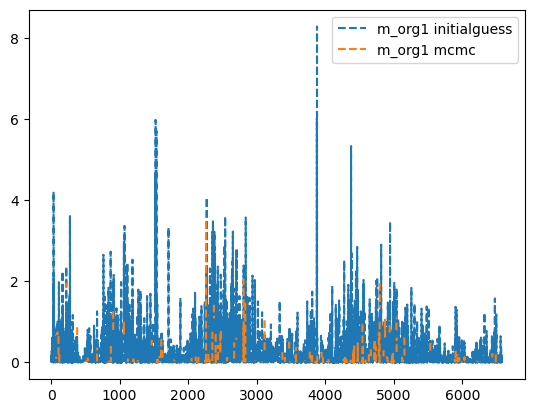

In [58]:
m_org1_guess = pd.read_csv('../input_data/M_org1_initialguess.csv')
#mcmc_params_m2 = pd.read_csv('../results/summary_30k_m2_5chains_20kburn.csv')

plt.plot(m_org1_guess, label='m_org1 initialguess', linestyle='--')
#plt.plot(mcmc_params_m2['M_org1_mean'], label='m_org1 cauchy', linestyle='--')
plt.plot(mcmc_params['M_org1_mean'], label='m_org1 mcmc', linestyle='--')
plt.legend()


In [48]:
# add season to mcmc_results:
def get_season(date):
    if date.month in [3, 4, 5]:
        return 0
    elif date.month in [6, 7, 8]:
        return 1
    elif date.month in [9, 10, 11]:
        return 2
    else:
        return 3
    

observed_results = pd.read_csv('../input_data/CCN.csv')
sc_cols = ['SC1', 'SC2', 'SC3', 'SC4', 'SC5']
observed_results['CCN'] = observed_results[sc_cols].values.tolist()

if nedmead_results['Predicted_CCN'].map(type).eq(str).any():
    nedmead_results['Predicted_CCN'] = nedmead_results['Predicted_CCN'].apply(
        lambda x: np.fromstring(x.strip('[]'), sep=' ') 
    )
if mcmc_results['Predicted_CCN'].map(type).eq(str).any():
    mcmc_results['Predicted_CCN'] = mcmc_results['Predicted_CCN'].apply(
        lambda x: np.fromstring(x.strip('[]'), sep=' ') if isinstance(x, str) else x
    )

# Helper to compute seasonal stats
def compute_seasonal_stats(df, column_name, label):
    seasonal_stats = []

    for season, group in df.groupby('season'):
        valid_rows = group[column_name].dropna()
        arrays = [np.array(row) for row in valid_rows if isinstance(row, (list, np.ndarray))]

        if arrays:
            stacked = np.vstack(arrays)
            seasonal_stats.append({
                'season': season,
                'source': label,
                'median': np.median(stacked, axis=0),
                'p25': np.percentile(stacked, 25, axis=0),
                'p75': np.percentile(stacked, 75, axis=0)
            })
        else:
            seasonal_stats.append({
                'season': season,
                'source': label,
                'median': np.nan,
                'p25': np.nan,
                'p75': np.nan
            })

    return pd.DataFrame(seasonal_stats)

# Apply to all datasets
mcmc_results['season'] = pd.to_datetime(mcmc_results['datetime']).apply(get_season)
nedmead_results['season'] = pd.to_datetime(nedmead_results['datetime']).apply(get_season)
observed_results['season'] = pd.to_datetime(observed_results['datetime']).apply(get_season)
mcmc_params['season'] = pd.to_datetime(mcmc_params['datetime']).apply(get_season)
bimodal_params['season'] = pd.to_datetime(bimodal_params['datetime']).apply(get_season)

seasonal_stats_mcmc = compute_seasonal_stats(mcmc_results.loc[rhat_index], 'Predicted_CCN', 'mcmc')
seasonal_stats_nedmead = compute_seasonal_stats(nedmead_results, 'Predicted_CCN', 'nedmead')
seasonal_stats_obs = compute_seasonal_stats(observed_results, 'CCN', 'observed')

#seasonal_stats_mcmc_rhatmorg = compute_seasonal_stats(mcmc_results.where(mcmc_params['M_org1_rhat']<1.2), 'Predicted_CCN', 'mcmc')

# Combine all into one DataFrame
seasonal_stats_all = pd.concat([seasonal_stats_mcmc, seasonal_stats_nedmead, seasonal_stats_obs], ignore_index=True)


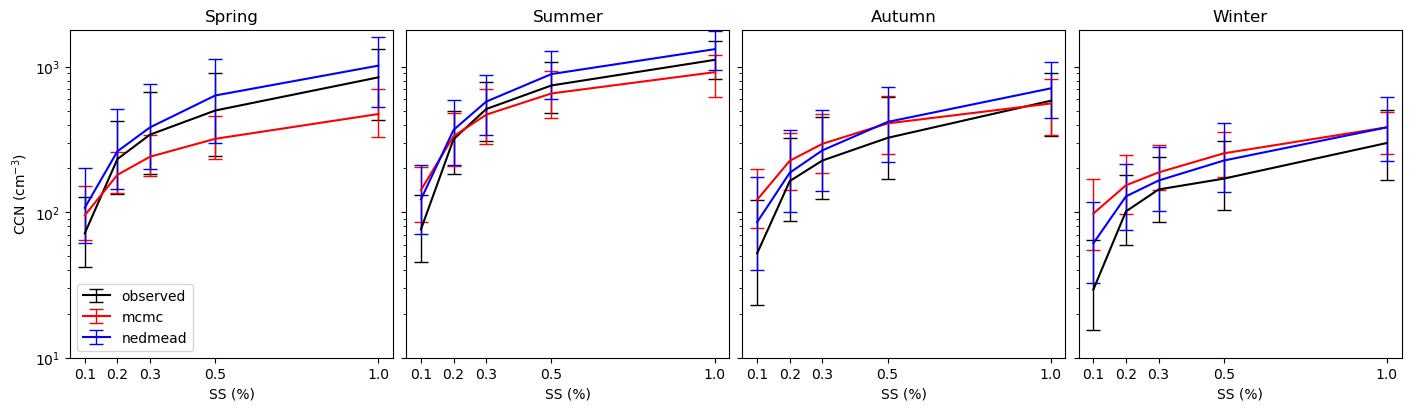

In [49]:
# plot CCN for each season:

fig,axes = plt.subplots(ncols=4, nrows=1, figsize=(14,4), sharey=True, constrained_layout=True)
ss = [0.1,0.2,0.3,0.5,1.0]

for i in range(4):
    for j, source in enumerate(['observed', 'mcmc', 'nedmead']):
        seasonal_data = seasonal_stats_all.loc[
            (seasonal_stats_all['season'] == i) & (seasonal_stats_all['source'] == source)
        ]
        
        if not seasonal_data.empty:
            median = seasonal_data['median'].iloc[0]
            p25 = seasonal_data['p25'].iloc[0]
            p75 = seasonal_data['p75'].iloc[0]

            # Calculate asymmetric error bars
            yerr_lower = median - p25
            yerr_upper = p75 - median
            yerr = np.vstack([yerr_lower, yerr_upper])  # shape (2, N)

            axes[i].errorbar(ss, median, yerr=yerr, label=source, color=['k', 'r', 'b'][j], capsize=5, elinewidth=1, markeredgewidth=1)
            #axes[i].set_xscale('log')
            axes[i].set_yscale('log')
            axes[i].set_title(['Spring', 'Summer', 'Autumn', 'Winter'][i])
            axes[i].set_ylim(1e1, 1.8e3)
            axes[i].set_xlabel('SS (%)')
            axes[i].set_xticks(ss)
        if i == 0:
            axes[i].set_ylabel('CCN (cm$^{-3}$)')
            axes[i].legend()


Text(0, 0.5, 'Counts')

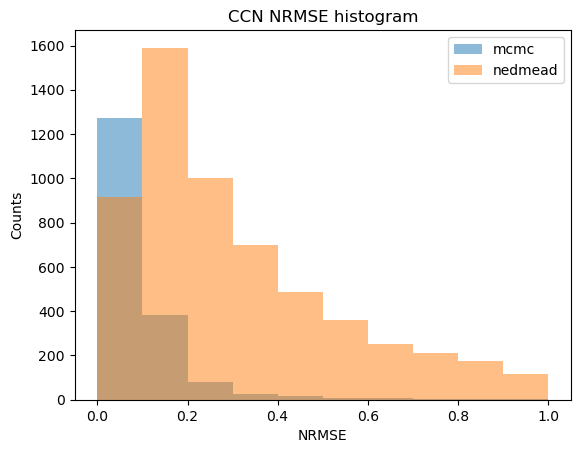

In [50]:
# histogram of different NRMSEs:
bins = np.linspace(0, 1, 11) 
plt.hist(mcmc_results['NRMSE'], bins=bins, alpha=0.5, label='mcmc')
plt.hist(nedmead_results['NRMSE'], bins=bins, alpha=0.5, label='nedmead')
plt.legend()
plt.title('CCN NRMSE histogram')
plt.xlabel('NRMSE')
plt.ylabel('Counts')

Text(0, 0.5, 'Probability Density')

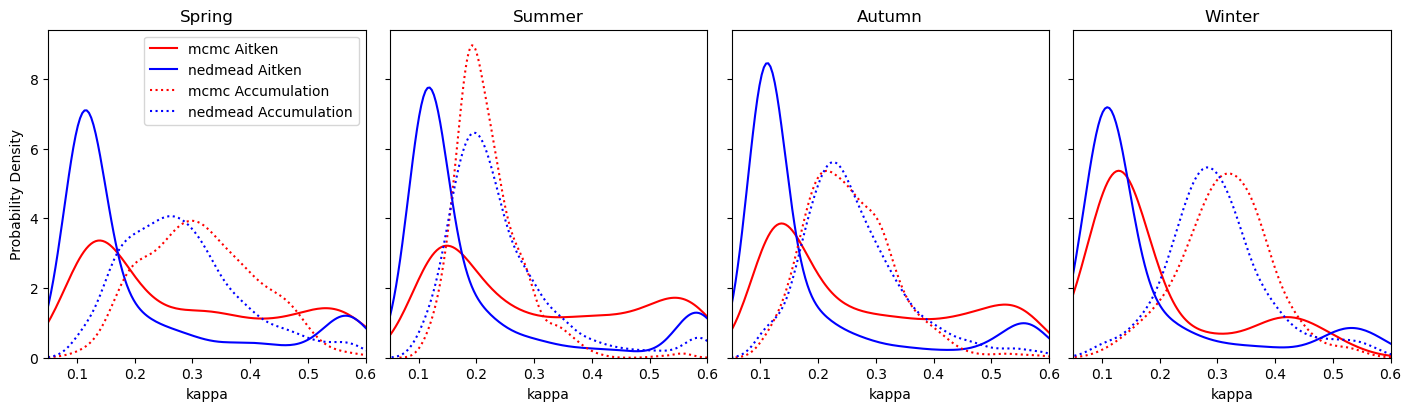

In [16]:
fig,axes = plt.subplots(ncols=4, nrows=1, figsize=(14,4), sharey=True, constrained_layout=True)

for season in range(4):
    ax = axes[season]

    #group_mcmc = mcmc_results.where(mcmc_params['M_org1_rhat']<1.5)[mcmc_results['season'] == season]
    group_mcmc = mcmc_results[mcmc_results['season'] == season]
    group_nedmead = nedmead_results[nedmead_results['season'] == season]
    sns.kdeplot(group_mcmc['k1'].dropna(), ax=ax, label='mcmc Aitken', color='r', linewidth=1.5)
    sns.kdeplot(group_nedmead['k1'].dropna(), ax=ax, label='nedmead Aitken', color='b', linewidth=1.5)
    sns.kdeplot(group_mcmc['k2'].dropna(), ax=ax, label='mcmc Accumulation', color='r', linestyle=':', linewidth=1.5)
    sns.kdeplot(group_nedmead['k2'].dropna(), ax=ax, label='nedmead Accumulation', color='b', linestyle=':', linewidth=1.5)

    ax.set_title(['Spring', 'Summer', 'Autumn', 'Winter'][season])
    ax.set_xlim(0.05, 0.6)
    ax.set_xlabel('kappa')

axes[0].legend()
axes[0].set_ylabel('Probability Density')


/tmp/ipykernel_1413347/1254240619.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(['Spring', 'Summer', 'Autumn', 'Winter'])
/tmp/ipykernel_1413347/1254240619.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(['Spring', 'Summer', 'Autumn', 'Winter'])


[Text(0, 0, 'Spring'),
 Text(1, 0, 'Summer'),
 Text(2, 0, 'Autumn'),
 Text(3, 0, 'Winter')]

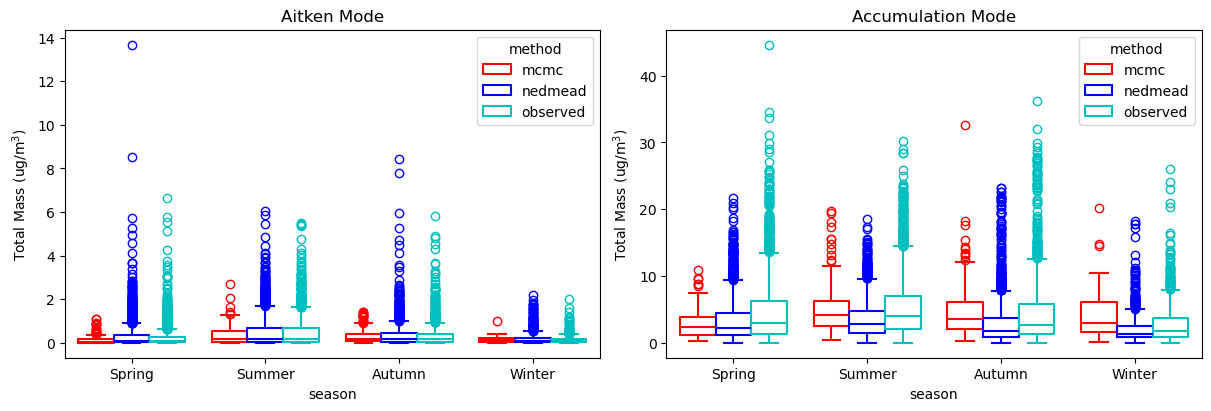

In [34]:
calc_mass = pd.read_csv('/proj/bolinc/users/x_maude/CCN_closure/Modal-Aerosol-Composition/input_data/total_mass_median_NSDparams.csv')

mass_df = pd.DataFrame({
    'datetime': mcmc_results['datetime'],
    'mass_aitken': mcmc_results['mass_aitken'],
    'mass_accumulation': mcmc_results['mass_accumulation'],
    'season': mcmc_results['season'],
    'method': 'mcmc'
})
mass_df_nedmead = pd.DataFrame({
    'datetime': nedmead_results['datetime'],
    'mass_aitken': nedmead_results['mass_aitken'],
    'mass_accumulation': nedmead_results['mass_accumulation'],
    'season': nedmead_results['season'],
    'method': 'nedmead'
})
mass_df_obs = pd.DataFrame({
    'datetime': calc_mass['datetime'],
    'mass_aitken': calc_mass['aitken_mass'],
    'mass_accumulation': calc_mass['accum_mass'],
    'season': mcmc_results['season'],
    'method': 'observed'
})
mass_df = pd.concat([mass_df, mass_df_nedmead, mass_df_obs], ignore_index=True)

fig,axes = plt.subplots(ncols=2, nrows=1, figsize=(12,4), constrained_layout=True)

sns.boxplot(x='season', y='mass_aitken', hue='method', data=mass_df, palette=['r','b','c'], fill=False, ax=axes[0])
sns.boxplot(x='season', y='mass_accumulation', hue='method', data=mass_df, palette=['r','b','c'], fill=False, ax=axes[1])
axes[0].set_title('Aitken Mode')
axes[1].set_title('Accumulation Mode')
axes[0].set_ylabel('Total Mass (ug/m$^3$)')
axes[1].set_ylabel('Total Mass (ug/m$^3$)')
axes[0].set_xticklabels(['Spring', 'Summer', 'Autumn', 'Winter'])
axes[1].set_xticklabels(['Spring', 'Summer', 'Autumn', 'Winter'])

Text(0, 0.5, 'Count')

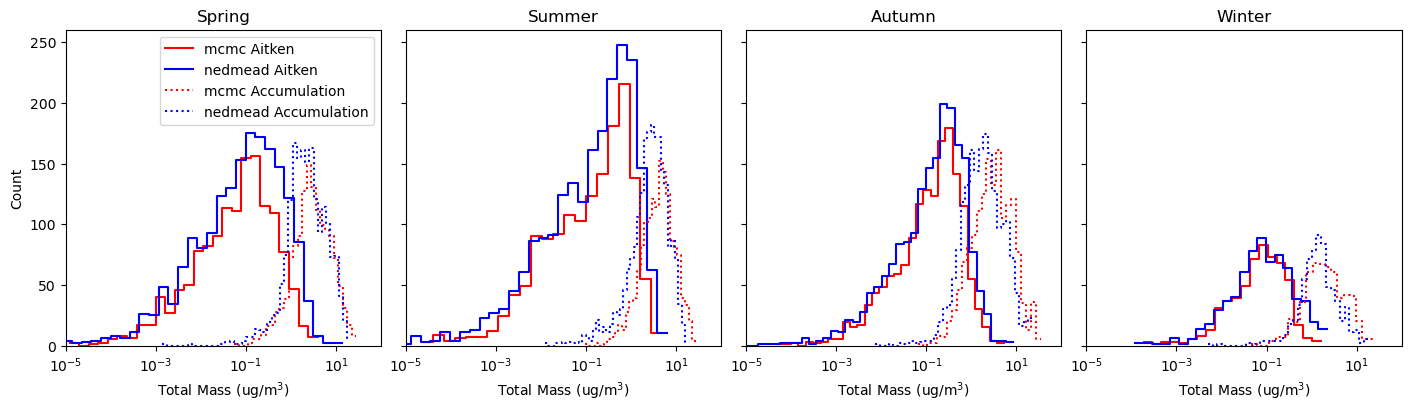

In [16]:
fig,axes = plt.subplots(ncols=4, nrows=1, figsize=(14,4), sharey=True, constrained_layout=True)

for season in range(4):
    ax = axes[season]

    group_mcmc = mcmc_results[mcmc_results['season'] == season]
    group_nedmead = nedmead_results[nedmead_results['season'] == season]
    sns.histplot(group_mcmc['mass_aitken'].dropna(), ax=ax, label='mcmc Aitken', color='r', linewidth=1.5,log_scale=True, element="step", fill=False)
    sns.histplot(group_nedmead['mass_aitken'].dropna(), ax=ax, label='nedmead Aitken', color='b', linewidth=1.5, log_scale=True, element="step", fill=False)
    sns.histplot(group_mcmc['mass_accumulation'].dropna(), ax=ax, label='mcmc Accumulation', color='r', linestyle=':', linewidth=1.5, log_scale=True, element="step", fill=False)
    sns.histplot(group_nedmead['mass_accumulation'].dropna(), ax=ax, label='nedmead Accumulation', color='b', linestyle=':', linewidth=1.5, log_scale=True, element="step", fill=False)

    ax.set_title(['Spring', 'Summer', 'Autumn', 'Winter'][season])
    ax.set_xlabel('Total Mass (ug/m$^3$)')
    ax.set_xlim(1e-5, 1e2)

 
axes[0].legend()
axes[0].set_ylabel('Count')

Text(0, 0.5, 'Density')

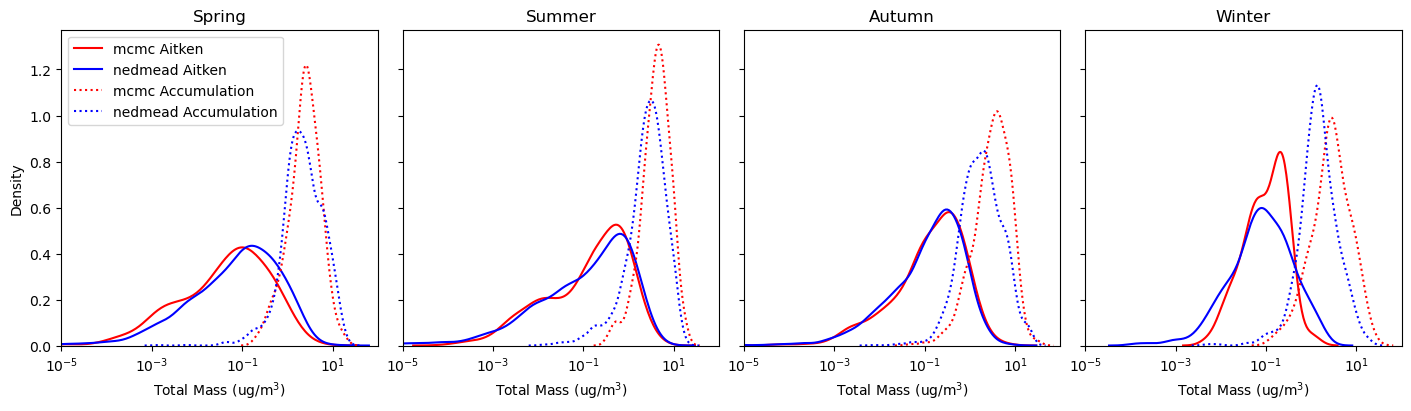

In [19]:
fig,axes = plt.subplots(ncols=4, nrows=1, figsize=(14,4), sharey=True, constrained_layout=True)

for season in range(4):
    ax = axes[season]

    group_mcmc = mcmc_results[mcmc_results['season'] == season]
    group_nedmead = nedmead_results[nedmead_results['season'] == season]
    sns.kdeplot(group_mcmc['mass_aitken'].dropna(), ax=ax, label='mcmc Aitken', color='r', linewidth=1.5,log_scale=True)
    sns.kdeplot(group_nedmead['mass_aitken'].dropna(), ax=ax, label='nedmead Aitken', color='b', linewidth=1.5, log_scale=True)
    sns.kdeplot(group_mcmc['mass_accumulation'].dropna(), ax=ax, label='mcmc Accumulation', color='r', linestyle=':', linewidth=1.5, log_scale=True)
    sns.kdeplot(group_nedmead['mass_accumulation'].dropna(), ax=ax, label='nedmead Accumulation', color='b', linestyle=':', linewidth=1.5, log_scale=True)

    ax.set_title(['Spring', 'Summer', 'Autumn', 'Winter'][season])
    ax.set_xlabel('Total Mass (ug/m$^3$)')
    ax.set_xlim(1e-5, 1e2)

 
axes[0].legend()
axes[0].set_ylabel('Density')

Text(0, 0.5, 'Count')

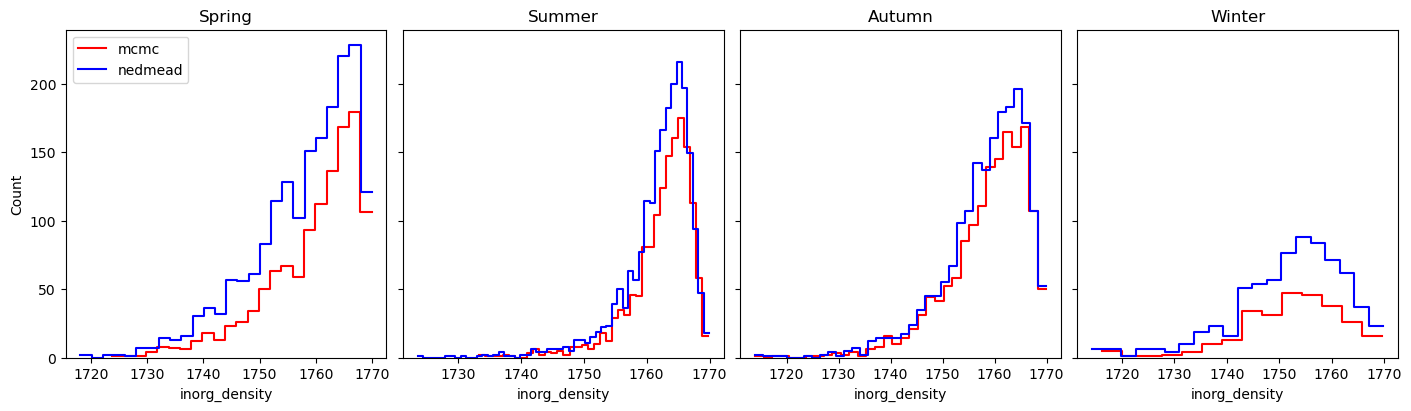

In [19]:
fig,axes = plt.subplots(ncols=4, nrows=1, figsize=(14,4), sharey=True, constrained_layout=True)

for season in range(4):
    ax = axes[season]

    group_mcmc = mcmc_results[mcmc_results['season'] == season]
    group_nedmead = nedmead_results[nedmead_results['season'] == season]
    sns.histplot(group_mcmc['inorg_density'].dropna(), ax=ax, label='mcmc', color='r', linewidth=1.5, element="step", fill=False)
    sns.histplot(group_nedmead['inorg_density'].dropna(), ax=ax, label='nedmead', color='b', linewidth=1.5, element="step", fill=False)

    ax.set_title(['Spring', 'Summer', 'Autumn', 'Winter'][season])
    ax.set_xlabel('inorg_density')

 
axes[0].legend()
axes[0].set_ylabel('Count')

Text(0, 0.5, 'Density')

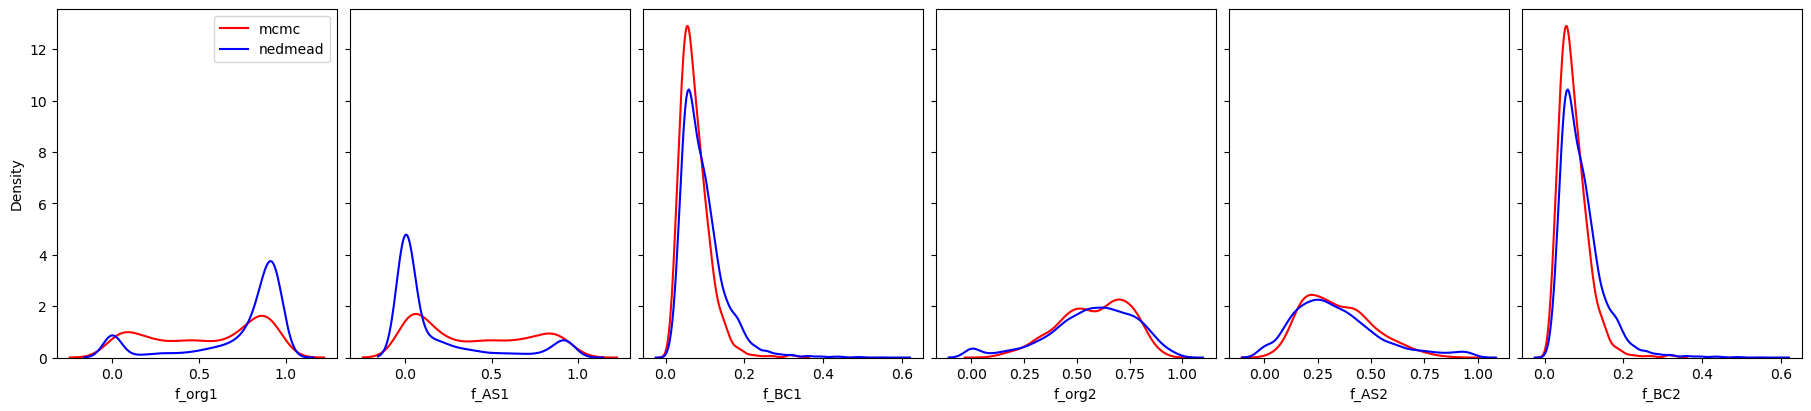

In [36]:
fig,axes = plt.subplots(ncols=6, nrows=1, figsize=(18,4), sharey=True, constrained_layout=True)
fractions = ['f_org1', 'f_AS1', 'f_BC1', 'f_org2', 'f_AS2', 'f_BC2']

for f in range(6):
    ax = axes[f]
    fraction = fractions[f]
    sns.kdeplot(mcmc_results.loc[rhat_index][fraction].dropna(), ax=ax, label='mcmc', color='r', linewidth=1.5)
    sns.kdeplot(nedmead_results[fraction].dropna(), ax=ax, label='nedmead', color='b', linewidth=1.5)

axes[0].legend()
axes[0].set_ylabel('Density')

NameError: name 'rhat_index' is not defined

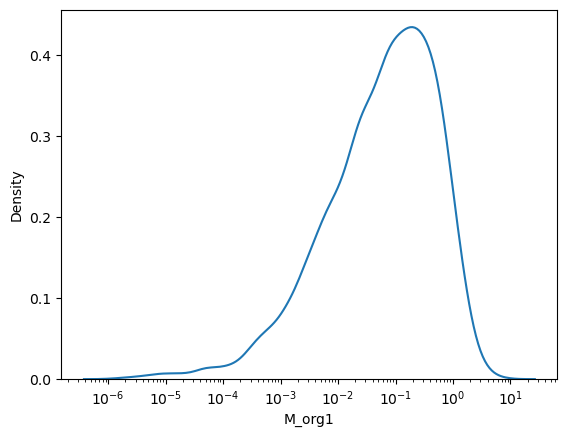

In [37]:
M_org1_initial = pd.read_csv('../input_data/M_org1_initialguess.csv')

sns.kdeplot(M_org1_initial['M_org1'], label='initial guess', log_scale=True)
sns.kdeplot((mcmc_results.loc[rhat_index]['mass_aitken']*mcmc_results['f_org1']), label='mcmc M_org1', log_scale=True)
sns.kdeplot((nedmead_results['mass_aitken']*nedmead_results['f_org1']).where((nedmead_results['mass_aitken']*nedmead_results['f_org1'])>0), label='nedmead M_org1', log_scale=True)
plt.legend()
plt.gca().set_xlim(1e-6, 1.5e1)

/tmp/ipykernel_2758943/3616874082.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group_mcmc = mcmc_params.loc[rhat_index][mcmc_params['season'] == season]
/tmp/ipykernel_2758943/3616874082.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group_mcmc = mcmc_params.loc[rhat_index][mcmc_params['season'] == season]
/tmp/ipykernel_2758943/3616874082.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group_mcmc = mcmc_params.loc[rhat_index][mcmc_params['season'] == season]
/tmp/ipykernel_2758943/3616874082.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group_mcmc = mcmc_params.loc[rhat_index][mcmc_params['season'] == season]


Text(0, 0.5, 'Probability Density')

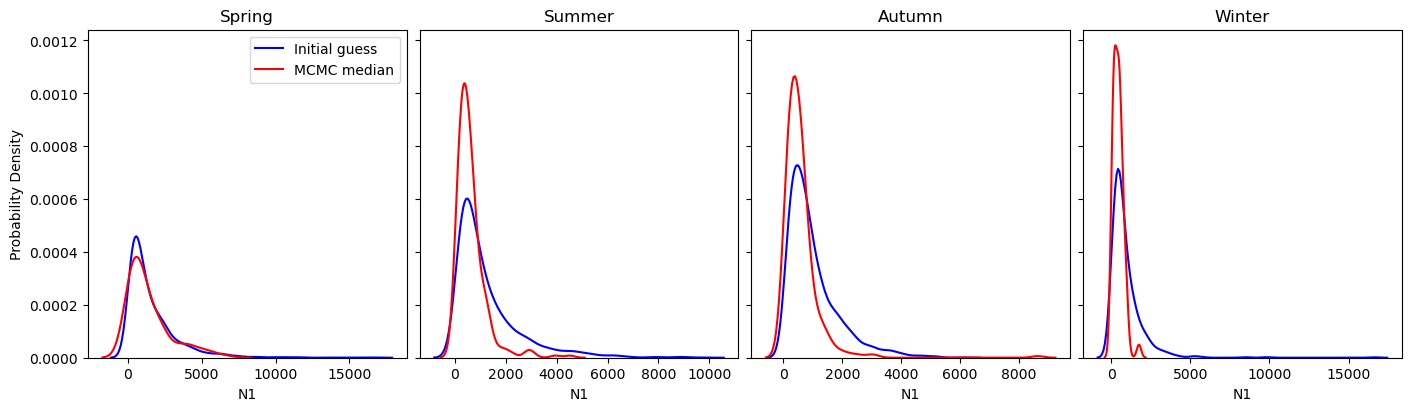

In [22]:
fig,axes = plt.subplots(ncols=4, nrows=1, figsize=(14,4), sharey=True, constrained_layout=True)

for season in range(4):
    ax = axes[season]

    #group_mcmc = mcmc_results.where(mcmc_params['M_org1_rhat']<1.5)[mcmc_results['season'] == season]
    group_mcmc = mcmc_params.loc[rhat_index][mcmc_params['season'] == season]
    group_initials = bimodal_params[bimodal_params['season'] == season]
    #group_nedmead = nedmead_results[nedmead_results['season'] == season]
    sns.kdeplot(group_initials['NSD1_sum'].where(group_initials['NSD1_sum']<20000).dropna(), ax=ax, label='Initial guess', color='b', linewidth=1.5)
    sns.kdeplot(group_mcmc['N1_median'].where(group_mcmc['N1_median']<20000).dropna(), ax=ax, label='MCMC median', color='r', linewidth=1.5)
    #sns.kdeplot(group_nedmead['k1'].dropna(), ax=ax, label='nedmead Aitken', color='b', linewidth=1.5)
    #sns.kdeplot(group_mcmc['k2'].dropna(), ax=ax, label='mcmc Accumulation', color='r', linestyle=':', linewidth=1.5)
    #sns.kdeplot(group_nedmead['k2'].dropna(), ax=ax, label='nedmead Accumulation', color='b', linestyle=':', linewidth=1.5)

    ax.set_title(['Spring', 'Summer', 'Autumn', 'Winter'][season])
    #ax.set_xlim(0.0, 100000)
    ax.set_xlabel('N1')

axes[0].legend()
axes[0].set_ylabel('Probability Density')

Text(0, 0.5, 'Probability Density')

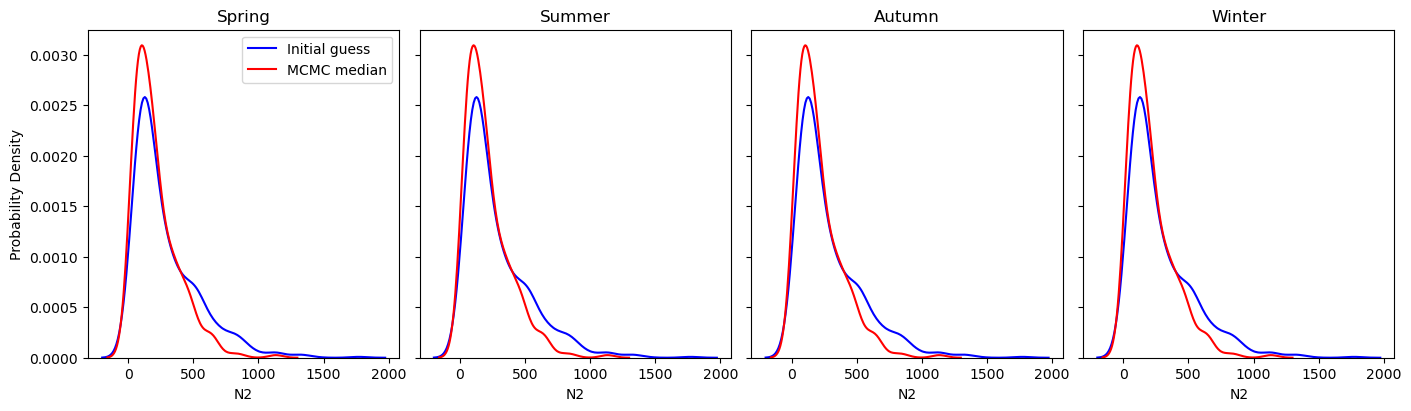

In [65]:
fig,axes = plt.subplots(ncols=4, nrows=1, figsize=(14,4), sharey=True, constrained_layout=True)

for season in range(4):
    ax = axes[season]

    sns.kdeplot(group_initials['NSD2_sum'].where(group_initials['NSD2_sum']<5000).dropna(), ax=ax, label='Initial guess', color='b', linewidth=1.5)
    sns.kdeplot(group_mcmc['N2_median'].where(group_mcmc['N2_median']<5000).dropna(), ax=ax, label='MCMC median', color='r', linewidth=1.5)

    ax.set_title(['Spring', 'Summer', 'Autumn', 'Winter'][season])
    #ax.set_xlim(0.0, 100000)
    ax.set_xlabel('N2')

axes[0].legend()
axes[0].set_ylabel('Probability Density')

Text(0, 0.5, 'Probability Density')

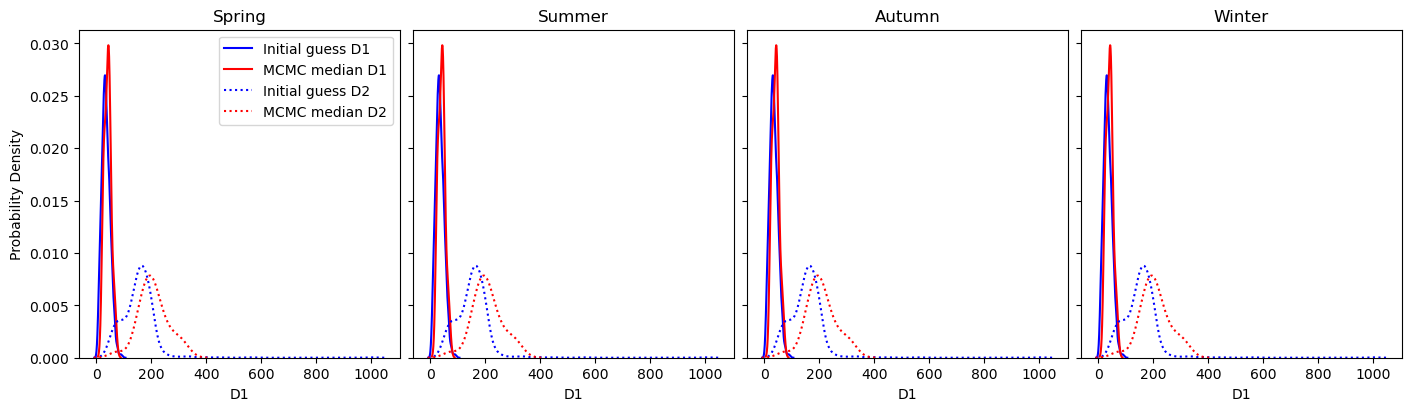

In [39]:
fig,axes = plt.subplots(ncols=4, nrows=1, figsize=(14,4), sharey=True, constrained_layout=True)

for season in range(4):
    ax = axes[season]

    sns.kdeplot(group_initials['mode1_d'].dropna(), ax=ax, label='Initial guess D1', color='b', linewidth=1.5)
    sns.kdeplot(group_mcmc['D1_median'].dropna(), ax=ax, label='MCMC median D1', color='r', linewidth=1.5)
    sns.kdeplot(group_initials['mode2_d'].dropna(), ax=ax, label='Initial guess D2', color='b', linestyle=':', linewidth=1.5)
    sns.kdeplot(group_mcmc['D2_median'].where(group_mcmc['D2_median']<1000).dropna(), ax=ax, label='MCMC median D2', color='r', linestyle=':', linewidth=1.5)

    ax.set_title(['Spring', 'Summer', 'Autumn', 'Winter'][season])
    #ax.set_xlim(0.0, 100000)
    ax.set_xlabel('D1')

axes[0].legend()
axes[0].set_ylabel('Probability Density')

Text(0.5, 1.0, 'Fitted vs MCMC number concentrations')

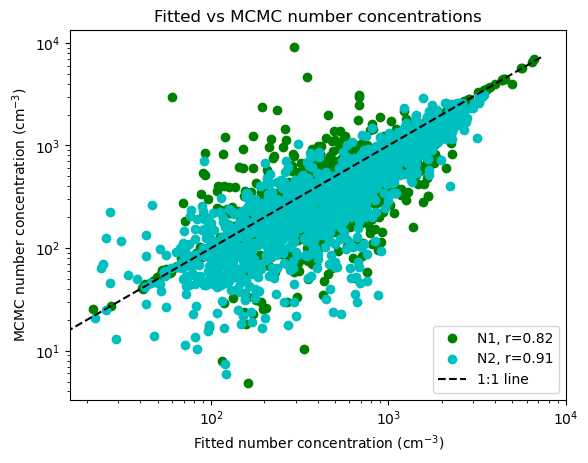

In [130]:
# compared observed and mcmc-fitted total number concentrations:

scaled_params = pd.read_csv('../input_data/bimodal_params_windows.csv')

r1,p1 = stats.pearsonr(scaled_params['NSD1_sum'].loc[rhat_index], mcmc_params['N1_median'].loc[rhat_index])
r2,p2 = stats.pearsonr(scaled_params['NSD2_sum'].loc[rhat_index], mcmc_params['N2_median'].loc[rhat_index])

plt.scatter(scaled_params['NSD1_sum'].loc[rhat_index], mcmc_params['N1_median'].loc[rhat_index], label='N1, r={:.2f}'.format(r1), color='g')
plt.scatter(scaled_params['NSD2_sum'].loc[rhat_index], mcmc_params['N2_median'].loc[rhat_index], label='N2, r={:.2f}'.format(r2), color='c')
plt.plot([0, 7500], [0, 7500], color='k', linestyle='--', label='1:1 line')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('Fitted number concentration (cm$^{-3}$)')
plt.ylabel('MCMC number concentration (cm$^{-3}$)')
plt.title('Fitted vs MCMC number concentrations')

In [15]:
import pickle
with open('../results/missing_windows_summary_30k_m2_5chains_20kburn.pickle', 'rb') as f:
    missing_windows = pickle.load(f)

In [17]:
len(missing_windows)

1321

In [80]:
np.max(M_org1_initial)

np.float64(8.290797022032539)

In [19]:
params = pd.read_csv('../input_data/bimodal_params_medians.csv',header=None, skiprows=2857+1, nrows=1).drop(columns=0).values[0]

In [20]:
params

array(['2018-08-25 13:00:00', 9.02418537008847, 1.6916666666666675,
       2361.3834872297803, 45.69573712059271, 1.5500000000000016,
       1825.1319620558288, 2272.6013561984228, 1940.775207385093,
       0.2741852258816273, 0.1916666666666662, 381.3540169757274,
       1.9280599360612636, 0.0666666666666669, 135.24171265623545,
       236.1702954815812, 97.8585042593927, 8], dtype=object)

In [26]:
pd.read_csv('../input_data/bimodal_params_windows.csv').loc[2857]

Unnamed: 0                       2857
datetime          2018-08-25 13:00:00
mode1_d                      9.024185
mode1_sigma                  1.691667
mode1_n                   2361.383487
mode2_d                     45.695737
mode2_sigma                      1.55
mode2_n                   1825.131962
NSD1_sum                  2272.601356
NSD2_sum                  1940.775207
mode1_d_max                 11.088663
mode1_d_min                  6.148766
mode1_d_mad                  0.274185
mode2_d_max                      74.0
mode2_d_min                 43.767677
mode2_d_mad                   1.92806
mode1_NSD_max             4953.715885
mode1_NSD_min             1931.371294
mode1_NSD_mad              236.170295
mode2_NSD_max             2298.443079
mode2_NSD_min              1555.93669
mode2_NSD_mad               97.858504
n_measurements                    6.0
Name: 2857, dtype: object

In [22]:
pd.read_csv('../input_data/bimodal_params_medians.csv').columns

Index(['Unnamed: 0', 'datetime', 'mode1_d', 'mode1_sigma', 'mode1_n',
       'mode2_d', 'mode2_sigma', 'mode2_n', 'NSD1_sum', 'NSD2_sum',
       'mode1_d_mad', 'mode1_sigma_mad', 'mode1_n_mad', 'mode2_d_mad',
       'mode2_sigma_mad', 'mode2_n_mad', 'NSD1_sum_mad', 'NSD2_sum_mad',
       'n_measurements'],
      dtype='object')

In [23]:
np.round(1.666666, 2)

np.float64(1.67)

In [25]:
pd.read_csv('../input_data/CCN.csv', header=None, skiprows=2857+1, nrows=1).drop(columns=0).values[0]

array([  51.82,  162.08,  269.12,  401.68, 1057.27])